#  Spatio-Temporal Analysis

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8428a8bb3181f0548cddca2749e3411b16547b7a8088cc2d15816fd005e34d39
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [36]:
import pyspark
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import Window
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [33]:
# Load datasets
df = spark.read.csv("Dataset/Preprocessed/cleaned_data.csv", header=True, inferSchema=True)
df_pd = df.toPandas()

## Analyzing Trends Over Time

In [40]:
# Function to get data to plot seasonal decompositions
def get_seasonal_data():
    seasonal_df = df.select("Current Date", "HCHO reading", "Location").toPandas()

    # Convert the Current Date column to datetime
    seasonal_df["Current Date"] = pd.to_datetime(seasonal_df["Current Date"])

    # Set date as the index
    seasonal_df.set_index("Current Date", inplace=True, drop=True)

    return seasonal_df

In [88]:
def plot_seasonal_decompose(location_df, location_name):
    # Filter data for the specific location
    location_df = location_df[location_df["Location"] == location_name]

    # Decompose the time series
    decomposition = seasonal_decompose(location_df["HCHO reading"], model='additive', period=365)

    # Plot the decomposition
    fig, axes = plt.subplots(4, 1, figsize=(12, 16))
    fig.suptitle(f"Seasonal Decomposition of HCHO Levels in {location_name}", fontsize=16, y=0.95)

    # Plot the original data
    decomposition.observed.plot(ax=axes[0])
    axes[0].set_ylabel('Original')

    # Show lockdown periods
    axes[0].axvline(pd.to_datetime('2020-03-01'), color='r', linestyle='--')
    axes[0].axvline(pd.to_datetime('2020-05-28'), color='r', linestyle='--')
    axes[0].axvline(pd.to_datetime('2021-08-01'), color='g', linestyle='--')
    axes[0].axvline(pd.to_datetime('2021-10-31'), color='g', linestyle='--')

    # Add legend for lockdown periods
    lockdown1 = plt.Line2D([], [], color='r', linestyle='--', label='Lockdown 1')
    lockdown2 = plt.Line2D([], [], color='g', linestyle='--', label='Lockdown 2')
    axes[0].legend(handles=[lockdown1, lockdown2],bbox_to_anchor=(1, 1))

    # Plot the trend component - Long-term progression or direction of the data, ignoring the short-term fluctuations and noise.
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_ylabel('Trend')

    # Show lockdown periods
    axes[1].axvline(pd.to_datetime('2020-03-01'), color='r', linestyle='--')
    axes[1].axvline(pd.to_datetime('2020-06-28'), color='r', linestyle='--')
    axes[1].axvline(pd.to_datetime('2021-08-01'), color='g', linestyle='--')
    axes[1].axvline(pd.to_datetime('2021-10-31'), color='g', linestyle='--')

    # Add legend for lockdown periods
    lockdown1 = plt.Line2D([], [], color='r', linestyle='--', label='Lockdown 1')
    lockdown2 = plt.Line2D([], [], color='g', linestyle='--', label='Lockdown 2')
    axes[1].legend(handles=[lockdown1, lockdown2],bbox_to_anchor=(1, 1))

    # Plot the seasonal component - Repetitive, periodic patterns in the data that occur at regular intervals.
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_ylabel('Seasonal')

    # Plot the residual component -  Random fluctuations or noise in the data that cannot be explained by the trend or seasonal components.
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_ylabel('Residual')

    plt.subplots_adjust(top=0.925, hspace=0.20)
    plt.show()
    print("\n")


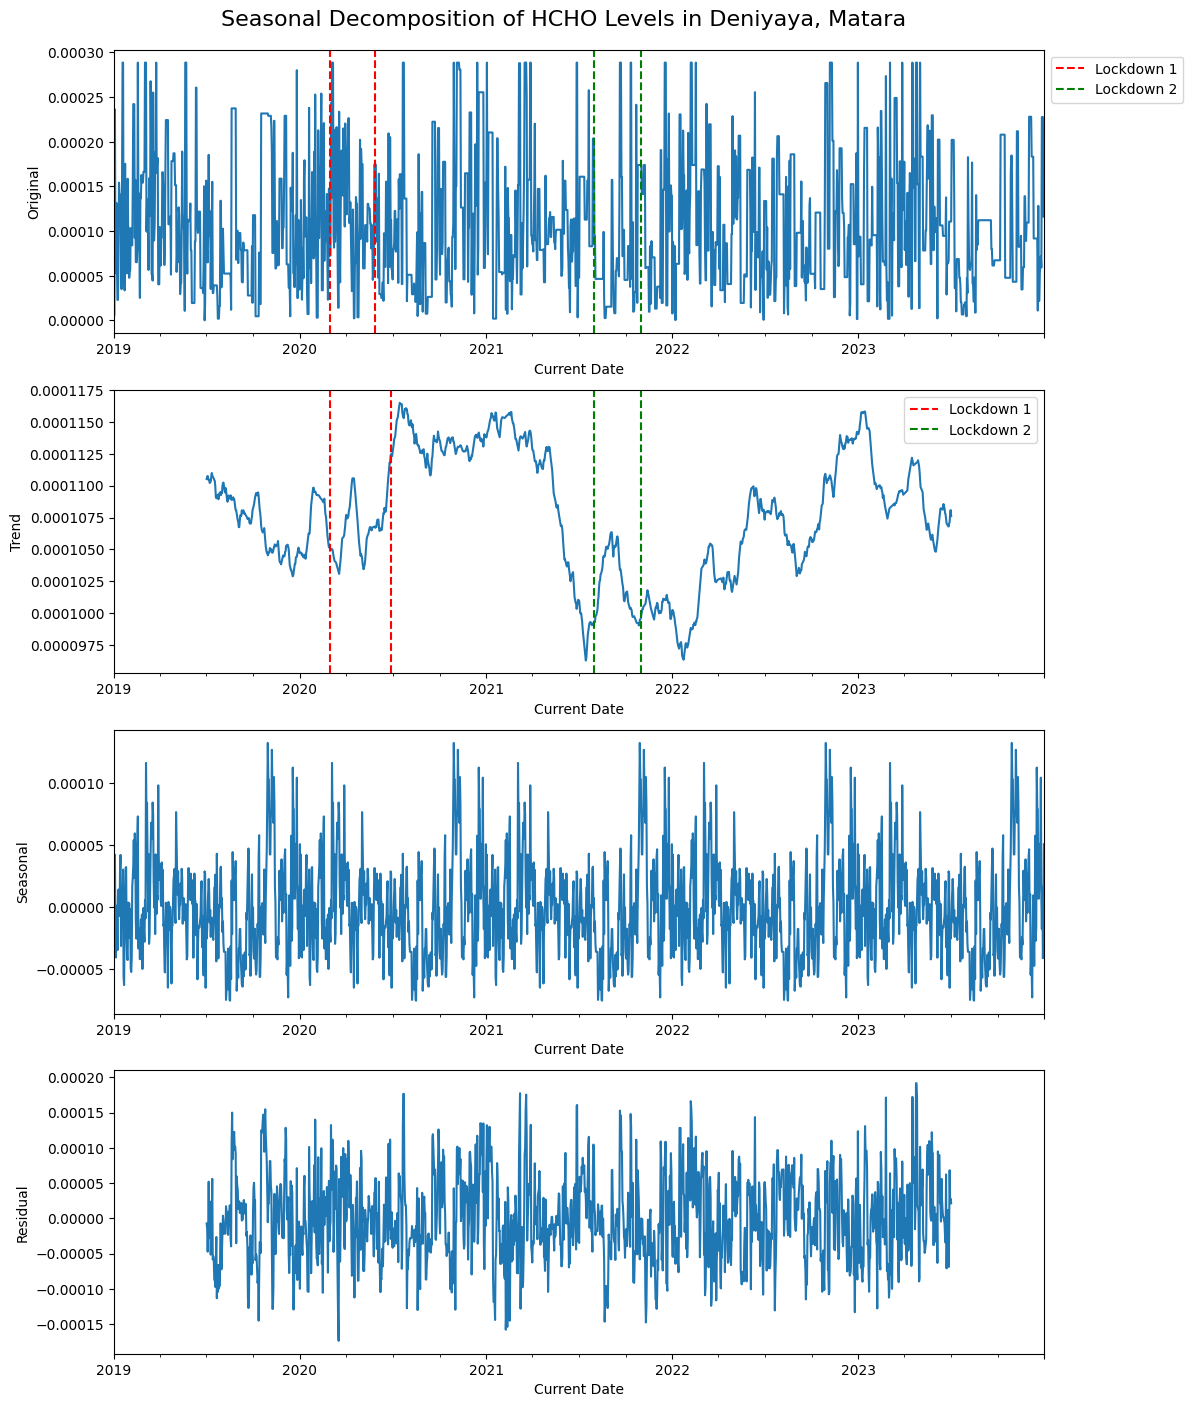

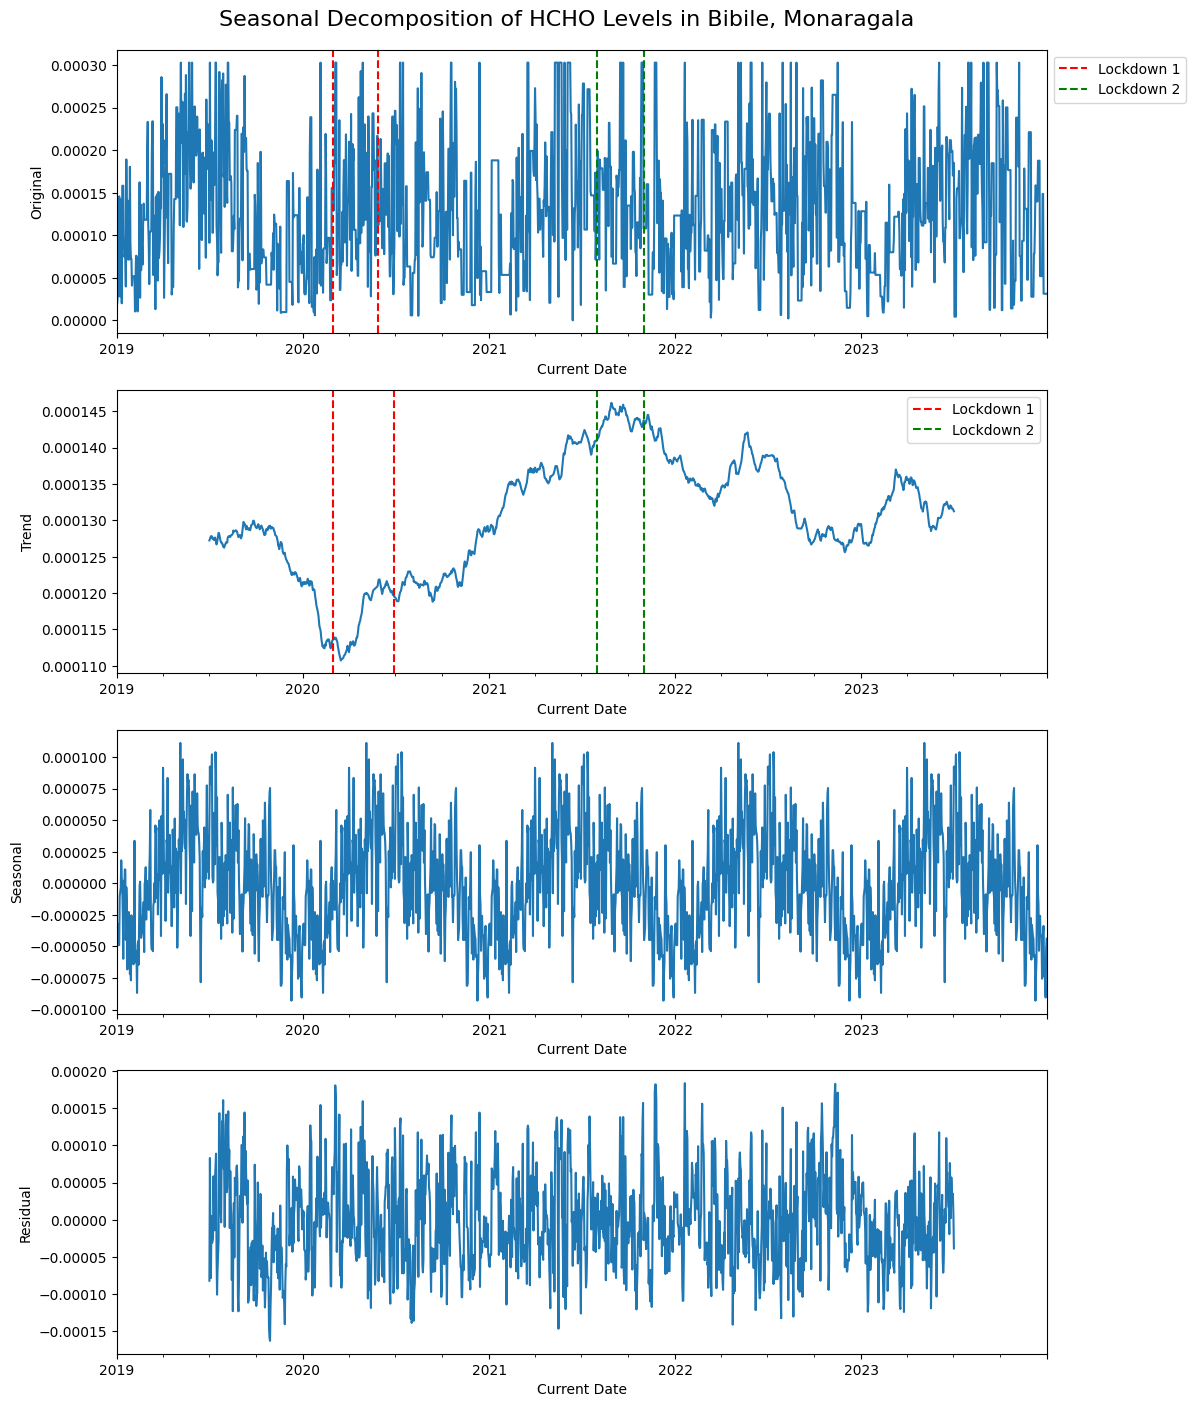

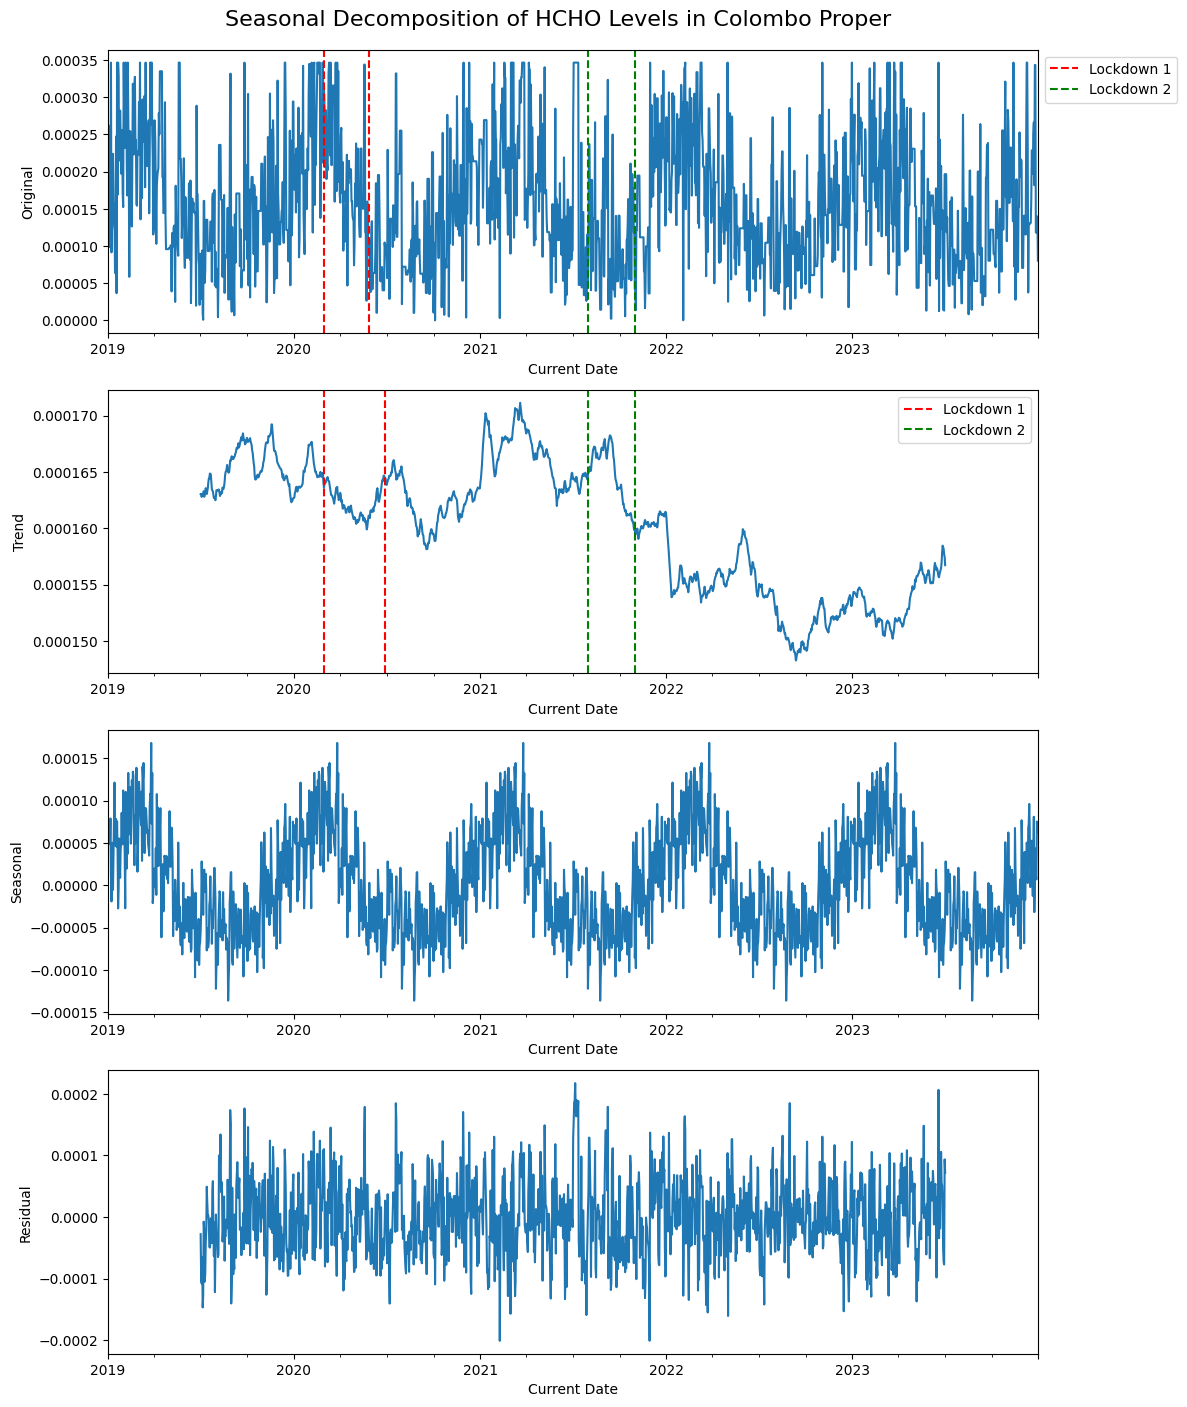

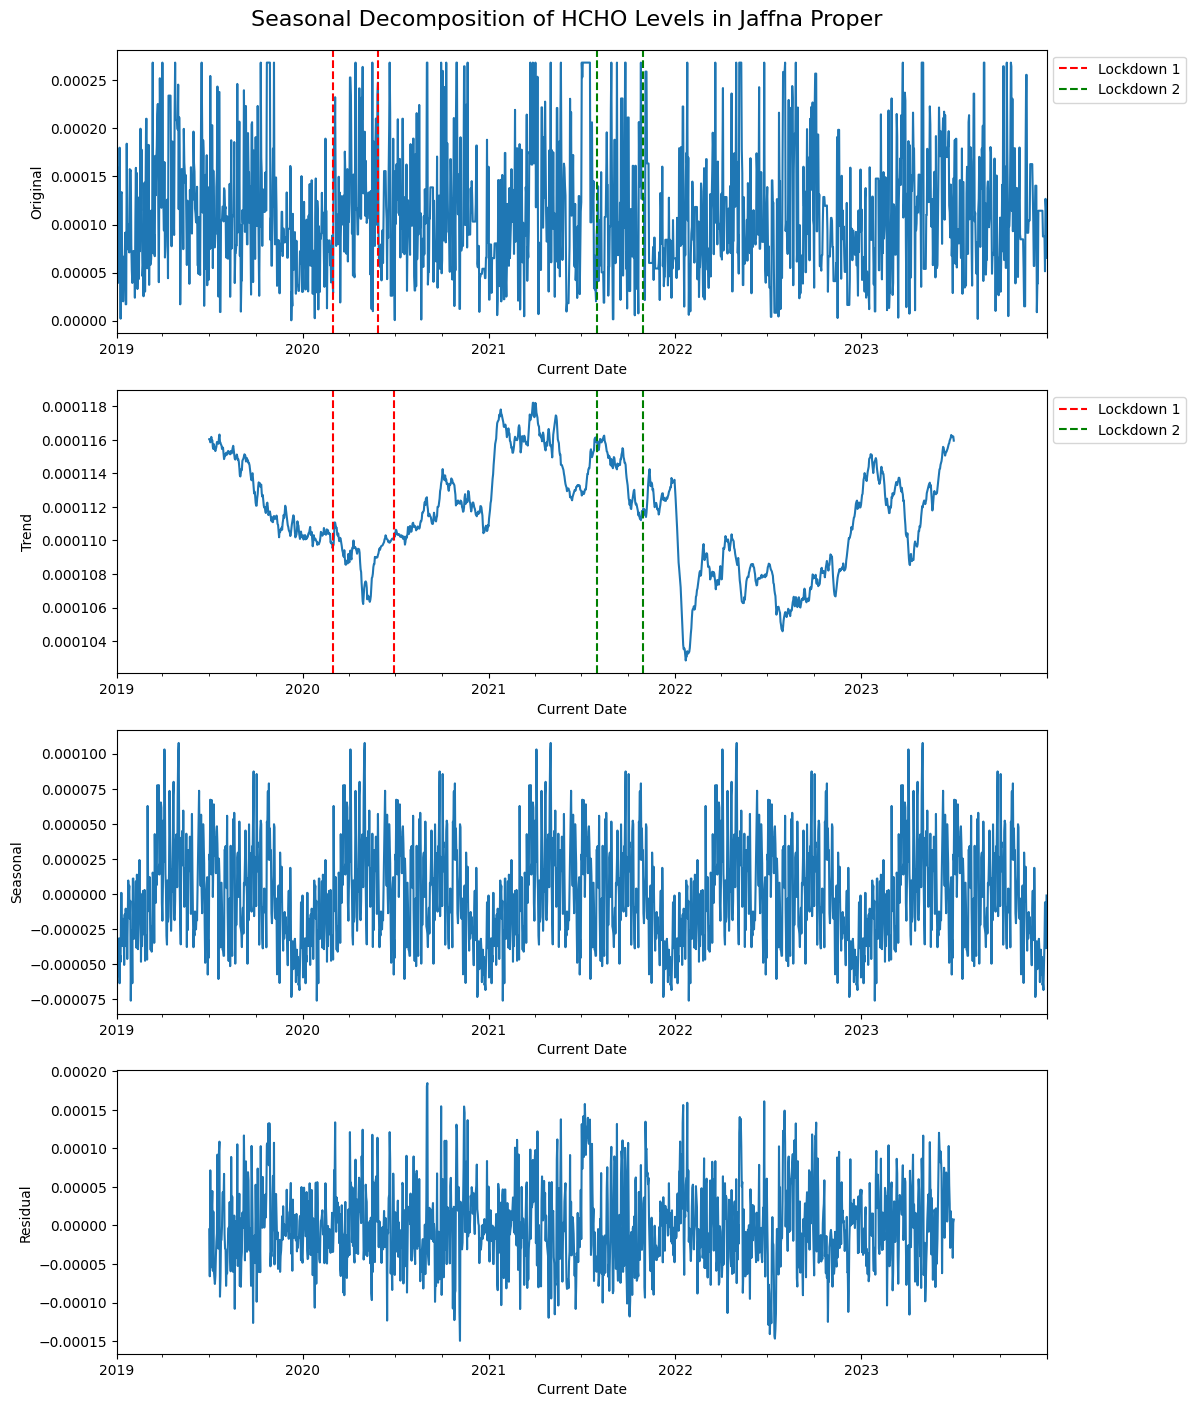

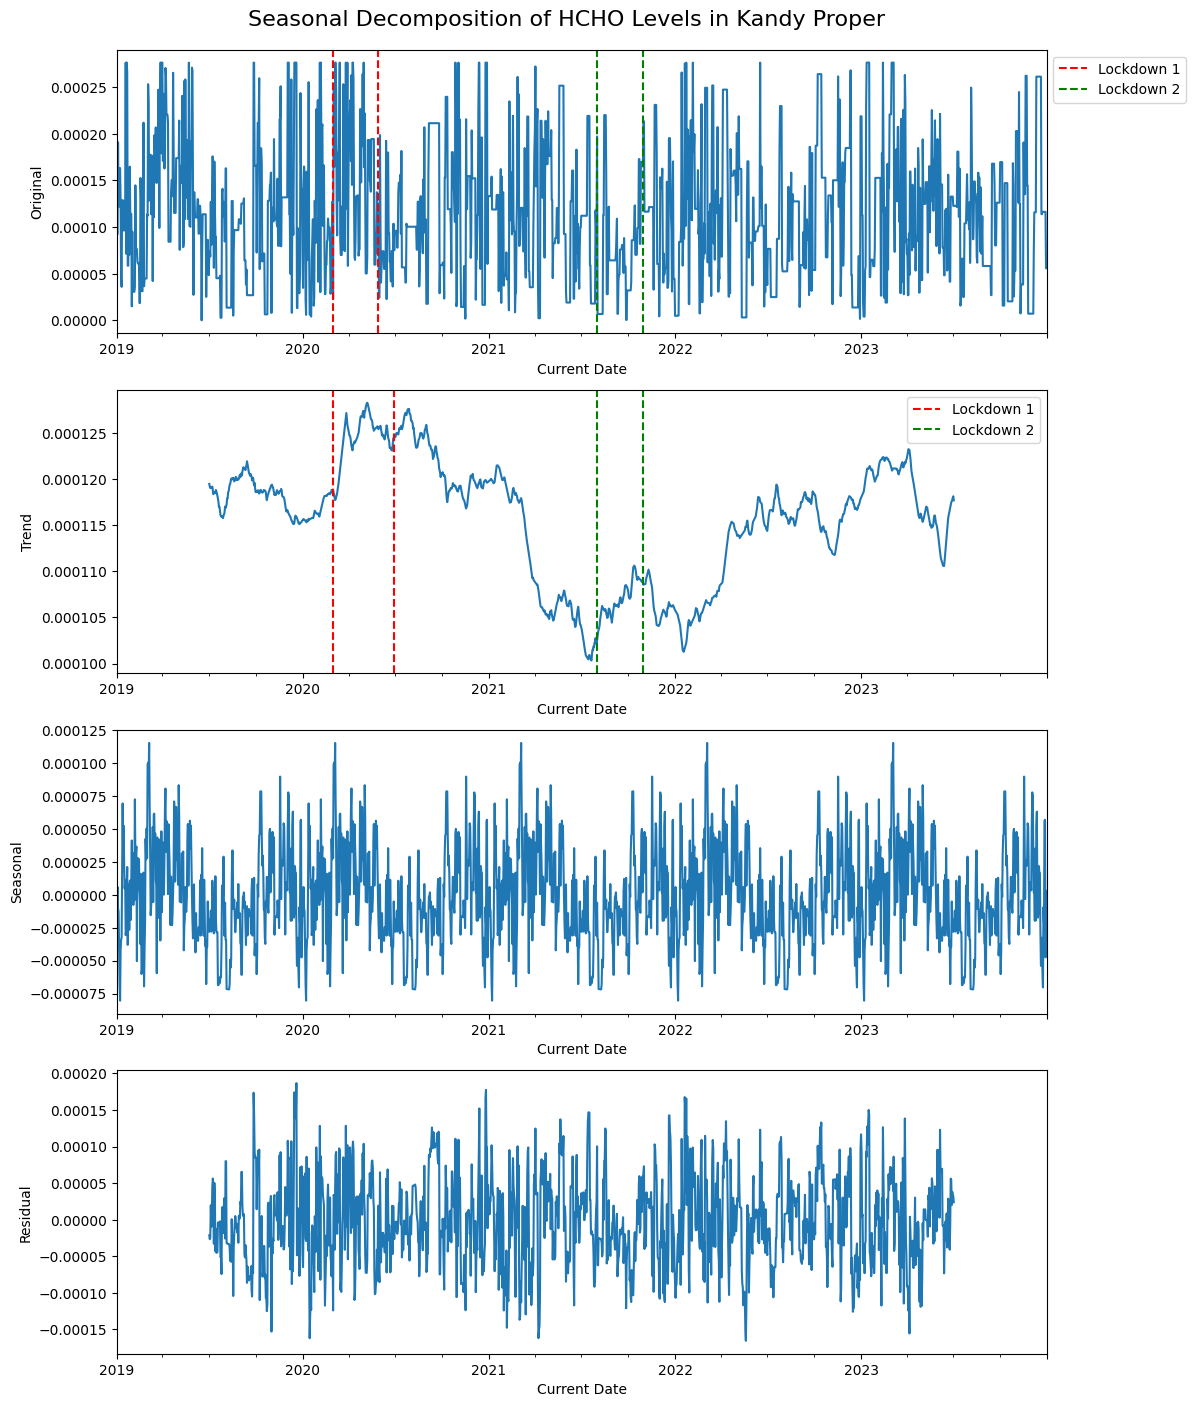

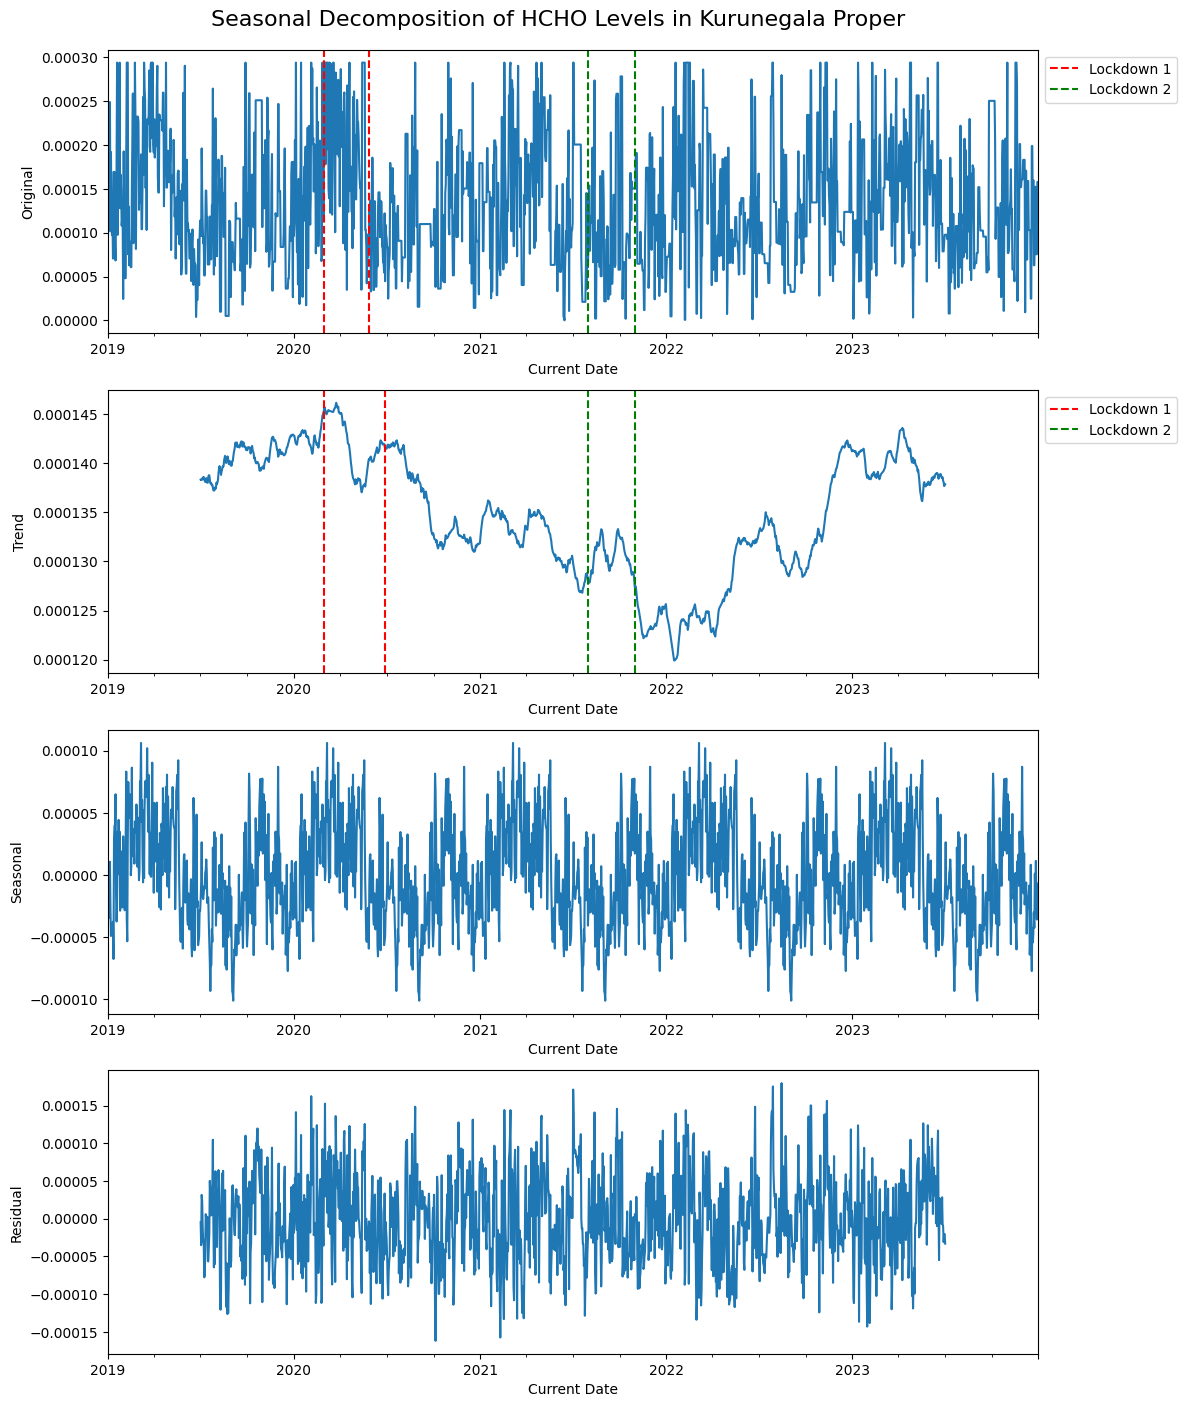

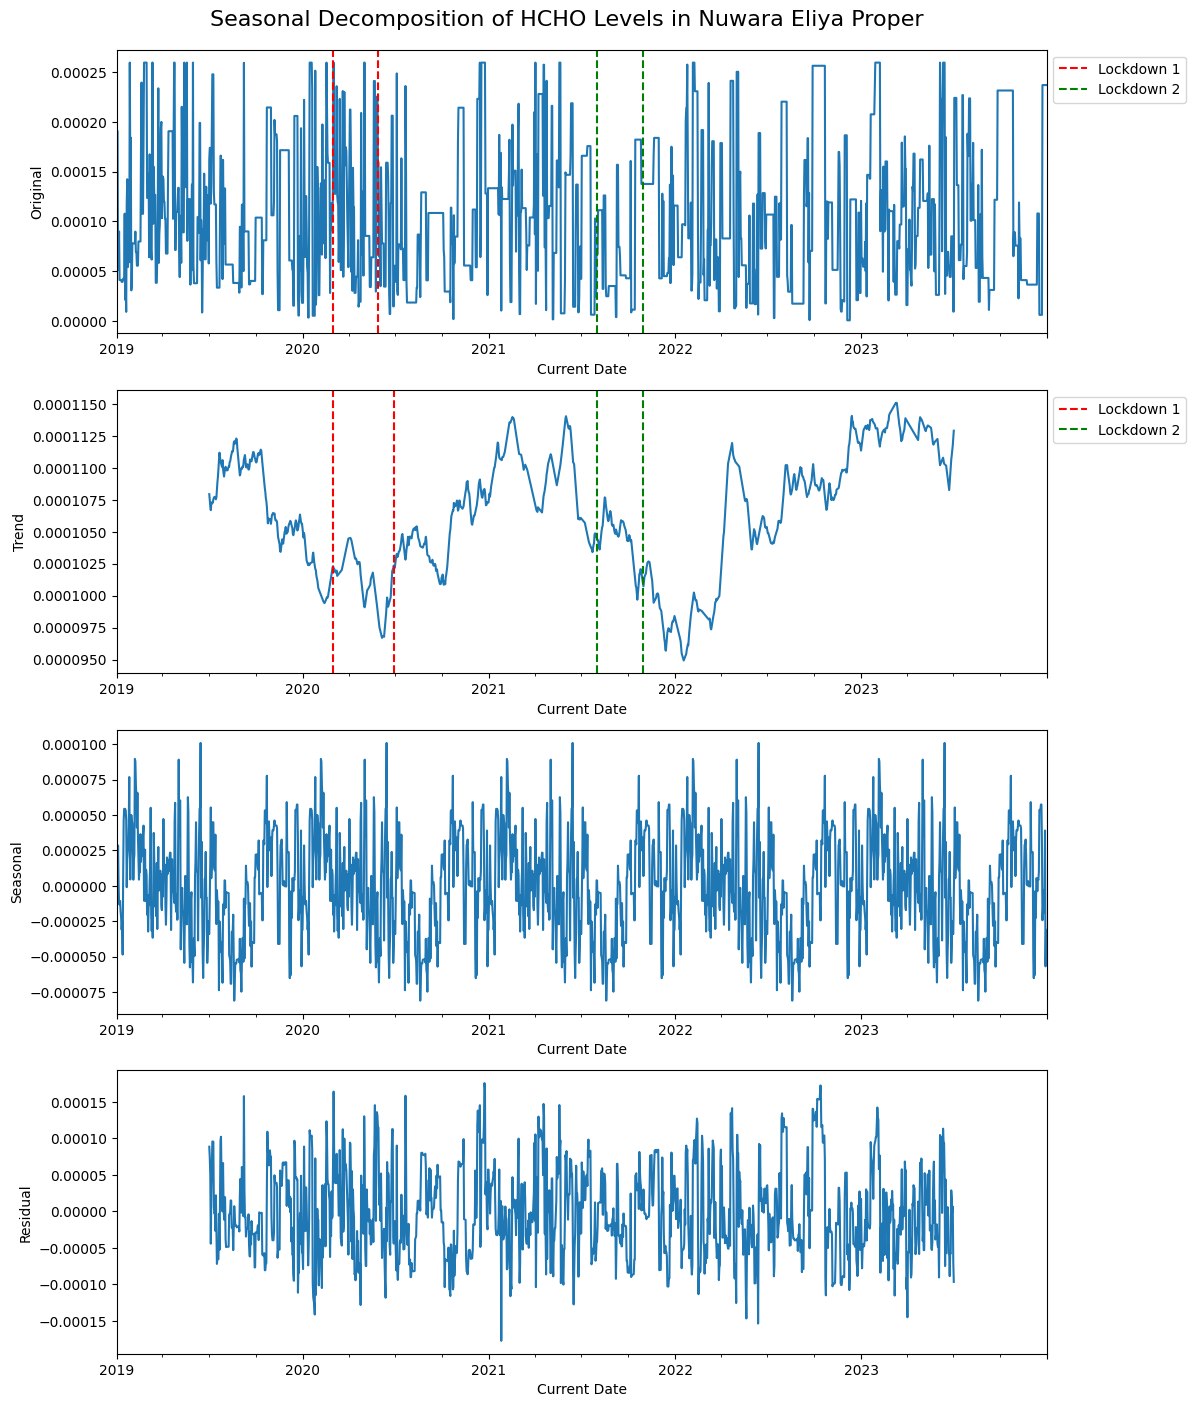

In [89]:
# Load the data
seasonal_df = get_seasonal_data()

# List of locations
locations = seasonal_df["Location"].unique()

# Plot seasonal decomposition for each location
for location_name in locations:
    plot_seasonal_decompose(seasonal_df, location_name)